# Visión general de los diferentes enfoques para poner en producción modelos de Machine Learning (ML)

Existen diferentes enfoques para poner modelos en producción con beneficios que pueden variar dependiendo del caso de uso específico. Tomemos, por ejemplo, el caso de uso de la predicción del índice de abandono de los clientes, ya que es valioso tener un valor estático que se puede consultar fácilmente cuando alguien llama a un servicio al cliente, pero se puede obtener algún valor adicional si, para eventos específicos, el modelo pudiera volver a ejecutarse con la información recién adquirida.

En general, existen diferentes formas de entrenar y servir los modelos en producción:

+ Entrenamiento: fuera de línea (one off), por lotes y en tiempo real/en línea.
+ Producción: Por lotes, Tiempo real (disparador de base de datos, Pub/Sub, servicio web, inApp)

Cada enfoque tiene su propio conjunto de beneficios y contras que deben considerarse.

## Entrenamiento One off

Los modelos no necesariamente tienen que ser entrenados continuamente para ser puestos en producción. Muy a menudo un modelo puede ser entrenado ad-hoc por un científico de datos puesto en producción hasta que su rendimiento se deteriore lo suficiente como para que lo actualicen.

Los prototipos de Científicos de Datos y el machine learning tienden a operar en entornos de [Jupyter Notebooks](https://jupyter.org/): Esencialmente una GUI avanzada [RPL](https://en.wikipedia.org/wiki/Read%E2%80%93eval%E2%80%93print_loop), que permite guardar tanto código como salidas de comando.

Usando ese enfoque es más que factible poner en producción un modelo entrenado ad-hoc desde algún fragmento de código en Jupyter. Los diferentes tipos de bibliotecas y otros proveedores de notebooks ayudan a vincular aún más el link entre el banco de trabajo del científico de datos y producción.

### Formato de modelo

[Pickle](https://docs.python.org/3/library/pickle.html) convierte un objeto Python en un flujo de bits y permite que se almacene en el disco y se vuelva a cargar en un momento posterior. Proporciona un buen formato para almacenar modelos de machine learning siempre que sus aplicaciones previstas también estén integradas en Python.

[ONNX](https://github.com/onnx), el formato Open Neural Network Exchange, es un formato abierto que admite el almacenamiento y la transferencia de modelos predictivos en bibliotecas y lenguajes. La mayoría de las bibliotecas de deep learning lo admiten y sklearn también tiene una extensión para convertir su modelo al formato de [ONNX](https://github.com/onnx/sklearn-onnx/blob/master/docs/tutorial.rst).

[PMML](https://en.wikipedia.org/wiki/Predictive_Model_Markup_Language) o lenguaje de marcado de modelo predictivo (*Predictive model markup language*) es otro formato de intercambio para modelos predictivos. Al igual que para ONNX, sklearn también tiene otra extensión para convertir los modelos al [formato PMML](https://github.com/jpmml/sklearn2pmml). Sin embargo, tiene el inconveniente de que solo admite cierto tipo de modelos de predicción. PMML ha existido desde 1997 y, por lo tanto, tiene una gran huella de aplicaciones que aprovechan el formato. Aplicaciones como [SAP](https://archive.sap.com/kmuuid2/a07faefd-61d7-2c10-bba6-89ac5ffc302c/Integrating%20Real-time%20Predictive%20Analytics%20into%20SAP%20Applications.pdf), por ejemplo, pueden aprovechar ciertas versiones del estándar PMML, al igual que las aplicaciones de CRM como [PEGA](https://community.pega.com/knowledgebase/supported-pmml-model-types).

[POJO y MOJO](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/productionizing.html#about-pojos-and-mojos) son el formato de exportación de [H2O.ai](https://www.h2o.ai/), que pretende ofrecer un modelo fácilmente integrable en aplicaciones java. Sin embargo, son muy específicos al uso de la plataforma de H2O.

### Entrenamiento

Para un entrenamiento One off, el modelo puede ser entrenado y afinado por científicos de datos o entrenamiento a través de las librerías de AutoML. Sin embargo, tener una configuración fácilmente reproducible ayuda a pasar a la siguiente etapa de la industrialización, es decir: entrenamiento por lotes.

## Entrenamiento por lotes

Si bien no es completamente necesario implementar un modelo en producción, el entrenamiento por lotes permite tener una versión actualizada de su modelo en base al último entrenamiento.

El entrenamiento por lotes puede beneficiarse mucho de frameworks de tipo AutoML. AutoML le permite realizar / automatizar actividades como el procesamiento de características, la selección de características, las selecciones de modelos y la optimización de parámetros. Su desempeño reciente ha estado a la par o superado a los científicos de datos más diligentes.

[Post Linkedin](https://www.linkedin.com/pulse/future-data-science-one-image-charles-givre/?fbclid=IwAR0zVvLTmiDT4ReAqe59HjCXym_pNXW6AvC2RgeC-zY5sEESnhKHYI_TfT8)

Su uso permite un entrenamiento de modelo más completo que el que se hacía normalmente antes de su ascenso: simplemente reentrenando los pesos del modelo.

Existen diferentes tecnologías que están diseñadas para admitir este entrenamiento por lotes continuo, por ejemplo, se pueden configurar a través de una combinación de [airflow](https://medium.com/analytics-and-data/airflow-the-easy-way-f1c26859ee21) para administrar los diferentes flujos de trabajo y una librería de AutoML como [tpot](https://epistasislab.github.io/tpot/). Diferentes proveedores de nube ofrecen sus soluciones para AutoML que se pueden implementar en workflow de datos. Azure, por ejemplo, integra la predicción de machine learning y entrenamiento de modelos con su [oferta de fábrica de datos](https://azure.microsoft.com/es-es/blog/retraining-and-updating-azure-machine-learning-models-with-azure-data-factory/).

## Entrenamiento en Tiempo Real

El entrenamiento en tiempo real es posible con los modelos de "Machine Learning en línea". Los algoritmos que soportan este método de entrenamiento incluyen K-means (a través de mini-lotes), Regresión lineal y logística (a través de Stochastic Gradient Descent) y el clasificador Naive Bayes.

Spark tiene StreamingLinearAlgorithm / StreamingLinearRegressionWithSGD para realizar estas operaciones, sklearn tiene SGDRegressor y SGDClassifier que se pueden entrenar de manera incremental. En sklearn, el entrenamiento incremental se realiza a través del método partial_fit como se muestra a continuación:

In [1]:
import pandas as pd
from sklearn import linear_model


X_0 = pd.DataFrame([[0,0], [1,0]] )
y_0 = pd.DataFrame([[0], [0]])

X_1 = pd.DataFrame([[0,1], [1,1], [1,1]])
y_1 = pd.DataFrame([[1], [1], [1]])

clf = linear_model.SGDClassifier()

clf.partial_fit(X_0, y_0, classes=[0,1])
print(clf.predict([[0,0]])) # -> 0
print(clf.predict([[0,1]])) # -> 0

clf.partial_fit(X_1, y_1, classes=[0,1])
print(clf.predict([[0,0]])) # -> 0
print(clf.predict([[0,1]])) # -> 1

[0]
[0]
[1]
[1]


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Al implementar este tipo de modelos debe haber un serio soporte y monitorización operativo, ya que el modelo puede ser sensible a nuevos datos y ruido, y el rendimiento del modelo debe ser monitorizado sobre la marcha. En el entrenamiento offline, puede filtrar puntos de [alta influencia (high leverage)](https://en.wikipedia.org/wiki/Leverage_%28statistics%29) y corregir este tipo de datos entrantes. Esto es mucho más difícil de hacer cuando se actualiza constantemente el entrenamiento de su modelo en base a un flujo de nuevos puntos de datos.

Otro desafío que se presenta con el modelo de entrenamiento en línea es que no degradan la información histórica. Esto significa que, en caso de que haya cambios estructurales en sus conjuntos de datos, el modelo tendrá que volver a reentrenarse y habrá una gran responsabilidad en la gestión del ciclo de vida del modelo.

## Predicción por lotes vs en tiempo real

Al ver si configurar una predicción por lotes o en tiempo real, es importante comprender por qué sería importante hacer una predicción en tiempo real. Puede ser potencialmente para obtener una nueva puntuación cuando ocurra un evento significativo. Por ejemplo, cuál sería el ratio de abandono de clientes cuando llaman a un centro de atención al cliente. Estos beneficios deben sopesarse frente a la complejidad y las implicaciones de costo que surgen de las predicciones en tiempo real.

### Implicaciones de carga

Atender a la predicción en tiempo real requiere una forma de manejar la carga máxima. Dependiendo del enfoque adoptado y de cómo se use la predicción elegir un enfoque en tiempo real también puede requerir tener una máquina con potencia de cómputo adicional disponible para proporcionar una predicción dentro de un determinado SLA. Esto contrasta con un enfoque por lotes en el que el cálculo de predicciones se puede distribuir a lo largo del día en función de la capacidad disponible.

### Implicaciones de infraestructura

Yendo en tiempo real pongo una responsabilidad operativa mucho mayor. Las personas deben poder monitorizar cómo funciona el sistema, recibir alertas cuando hay un problema y tomar alguna consideración con respecto a la responsabilidad de *failover*. Para la predicción de lotes, la obligación operativa es mucho menor, definitivamente se necesita cierta monitorización y se desea realizar modificaciones, pero la necesidad de poder conocer los problemas que surgen directamente es mucho menor.

### Implicaciones de coste

Ir a predicciones en tiempo real también tiene implicaciones en cuanto a costos, más potencia de computación, no poder distribuir la carga a lo largo del día puede forzar la compra de más capacidad de computación de la que necesitaría o pagar el aumento del precio de compra. Dependiendo del enfoque y los requisitos adoptados, también puede haber un costo adicional debido a la necesidad de una capacidad de cómputo más potente para cumplir con los SLA. Además, tendería a tener un espacio de infraestructura más alto al elegir las predicciones en tiempo real. Una posible excepción es donde la decisión se basa en la predicción de la aplicación, para ese escenario específico, el costo podría llegar a ser más barato que ir por un enfoque por lotes.

### Implicaciones de evaluación

La evaluación del rendimiento de la predicción en tiempo real puede ser más difícil que para las predicciones por lotes. ¿Cómo evalúa el desempeño cuando se enfrenta a una sucesión de acciones en una breve ráfaga que produce múltiples predicciones para un cliente determinado, por ejemplo? La evaluación y depuración de los modelos de predicción en tiempo real son significativamente más complejos de administrar. También requieren un mecanismo de recopilación de registros que permita recopilar las diferentes predicciones y características que dieron lugar a la puntuación para una evaluación adicional.

## Integración de la Predicción por Lotes

Las predicciones por lotes se basan en dos conjuntos diferentes de información, uno es el modelo predictivo y el otro son las características con las que alimentaremos al modelo. En la mayoría de los tipos de arquitectura de predicción por lotes, se realiza ETL para obtener características precalculadas de un almacén de datos específico (*feature-store*) o realizar algún tipo de transformación en múltiples conjuntos de datos para proporcionar la entrada al modelo predictivo. El modelo preedictivo luego itera sobre todas las filas en los conjuntos de datos que proporcionan las diferentes puntuaciones.

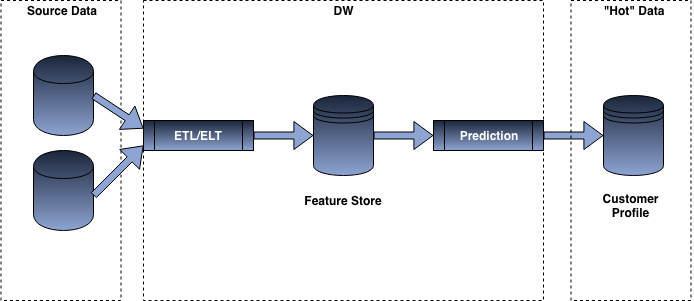

In [2]:
from IPython.display import Image
Image(filename="./image/flow_model_batch_prediction.png")

*Ejemplo de flujo de modelo sirviendo para predicciones por lotes*

Una vez que se han calculado todas las predicciones, podemos "servir" la puntuación a los diferentes sistemas que desean consumir la información. Esto se puede hacer de una manera diferente según el caso de uso en el que queremos consumir la puntuación. Por ejemplo, si quisiéramos consumir la puntuación en una aplicación de aplicaciones front-end, lo más probable es que empujemos los datos a una "caché" o base de datos NoSQL, como Redis, por lo que podemos ofrecer respuestas en milisegundos, mientras que para ciertos casos de uso como la creación de un viaje por email, podríamos estar confiando en una exportación CSV SFTP o en una carga de datos a un RDBMS más tradicional.

## Integración de Predicciones en Tiempo Real

Ser capaz de llevar el modelo a producción para aplicaciones en tiempo real requiere tres componentes básicos. Un perfil de cliente / usuario, un conjunto de disparadores y modelos predictivos.

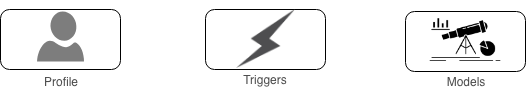

In [3]:
Image(filename="./image/componentes_basicos_tiempo_real.png")

**Profile**: El perfil del cliente contiene todos los atributos relacionados con el cliente, así como los diferentes atributos (por ejemplo, contadores) necesarios para realizar una predicción determinada. Esto es necesario para la predicción a nivel del cliente con el fin de reducir la latencia de la extracción de información desde múltiples lugares, así como para simplificar la integración de los modelos de aprendizaje automático en producción. En la mayoría de los casos, se necesitaría un tipo similar de almacén de datos para obtener efectivamente los datos necesarios para impulsar el modelo de predicción.

**Triggers**: Los disparadores son eventos que provocan el inicio del proceso. Pueden ser, por ejemplo para el abandono de un cliente, llamar a un centro de servicio al cliente, verificar la información dentro de su historial de pedidos, etc.

**Modelos**: los modelos deben haber sido entrenados previamente y, por lo general, exportados a uno de los tres formatos mencionados anteriormente (pickle, ONNX o PMML) para ser algo que podamos adaptar fácilmente a la producción.

Hay varios enfoques diferentes para poner modelos con fines de puntuación en producción:

+ *Confiando en la integración de la base de datos*: muchos de los proveedores de bases de datos han hecho un esfuerzo importante para vincular los casos de uso de análisis avanzado dentro de la base de datos. Ya sea por integración directa de Python o código R, a la importación del modelo PMML.
+ *Explotación de un modelo de Pub / Sub*: el modelo predictivo es esencialmente una aplicación que alimenta un flujo de datos y realiza ciertas operaciones, como extraer información del perfil del cliente.
+ *Servicio web*: configuración de un envoltorio de API alrededor de la predicción del modelo y su implementación como un servicio web. Dependiendo de la forma en que esté configurado el servicio web podría o no realizar la extracción o los datos necesarios para potenciar el modelo.
+ *inApp*: también es posible implementar el modelo directamente en una aplicación nativa o web y hacer que el modelo se ejecute en fuentes de datos locales o externas.


### Integración de base de datos

Si el tamaño total de su base de datos es bastante pequeño (<1M perfil de usuario) y la frecuencia de actualización es ocasional, puede tener sentido integrar parte del proceso de actualización en tiempo real directamente dentro de la base de datos.

PostgreSql posee una integración que permite ejecutar el código Python como funciones o procedimiento almacenado llamado [PL/Python](https://www.postgresql.org/docs/10/plpython.html). Esta implementación tiene acceso a todas las librerías que forman parte de **PYTHONPATH** y, por lo tanto, pueden usar librerías como Pandas y SKlearn para ejecutar algunas operaciones.

Esto se puede combinar con el mecanismo de [triggers](https://www.tutorialspoint.com/postgresql/postgresql_triggers.htm) de PostgreSql para realizar una ejecución de la base de datos y actualizar la puntuación de abandono. Por ejemplo, si se hace una nueva entrada a una tabla de quejas, sería valioso que el modelo se vuelva a ejecutar en tiempo real.

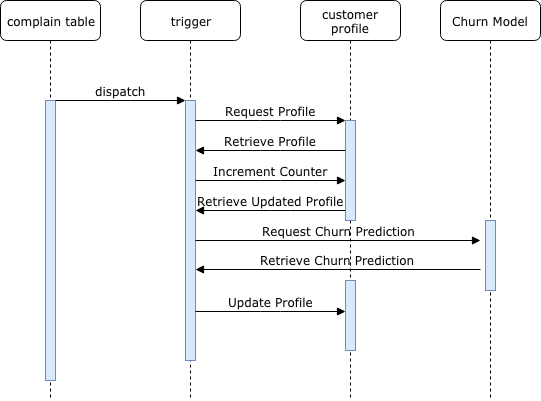

In [4]:
Image(filename="./image/trigger_bbdd.png")

#### Flujo de secuencia 

El flujo se podría configurar de la siguiente manera:

*Nuevo evento*: cuando se inserta una nueva fila en la tabla de quejas se genera un disparador de evento.

*Disparador*: la función de activación actualizaría la cantidad de reclamaciones realizadas por este cliente en la tabla de perfiles de clientes y recuperaría el registro actualizado para el cliente.

*Solicitud de predicción*: en base a eso, volvería a ejecutar el modelo de rotación a través de PL/Python y recuperaría la predicción.

*Actualización del perfil del cliente*: A continuación, puede volver a actualizar el perfil del cliente con la predicción actualizada. Los flujos descendentes pueden ocurrir luego de verificar si el perfil del cliente se ha actualizado con un nuevo valor de predicción de abandono.

#### Tecnologías

Diferentes bases de datos pueden admitir la ejecución de scripts de Python, este es el caso de PostgreSQL que tiene una integración nativa de Python como se mencionó anteriormente, pero también de MS SQLServer a través de su [Servicio de Machine Learning (en base de datos)](https://www.sqlshack.com/how-to-use-python-in-sql-server-2017-to-obtain-advanced-data-analytics/), otras bases de datos como Teradata pueden ejecutar el scripts de R / Python a través de un comando de script externo. Mientras que Oracle admite el [modelo PMML](https://docs.oracle.com/database/121/DMPRG/GUID-55C6ADBF-DA64-48B6-A424-5F0A59CD406D.htm#DMPRG701) a través de su extensión de minería de datos.

 ### Pub/Sub

La implementación de la predicción en tiempo real a través de un modelo de publicación / subscripción permite poder manejar adecuadamente la carga a través de la regulación. Para los ingenieros, también significa que solo pueden alimentar los datos del evento a través de una única fuente de "logging", a la que se pueden suscribir diferentes aplicaciones.

A continuación se muestra un ejemplo de cómo se podría configurar esto:

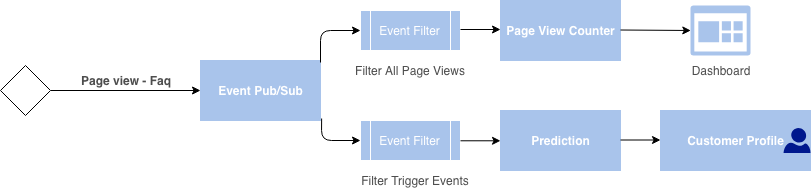

In [5]:
Image(filename="./image/pub_sub.png")

El evento de vista de página se dispara ante un tema específico en el que dos aplicaciones suscriben un contador de vista de página y una predicción. Ambas aplicaciones filtran eventos relevantes específicos del tema para su propósito y consumen los diferentes mensajes en los temas. La aplicación de contador de vista de página proporciona datos para alimentar un dashboard, mientras que la aplicación de predicción, actualiza el perfil del cliente.

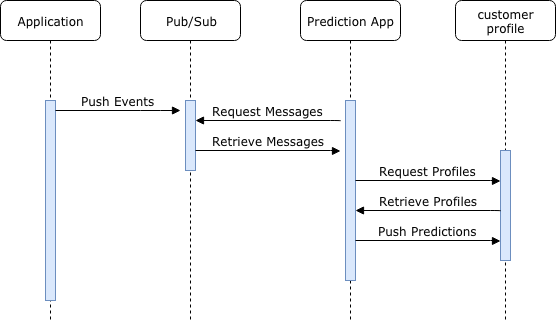

In [6]:
Image(filename="./image/pub_sub_flow.png")

#### Flujo de secuencia

Los mensajes de eventos se envían al tema del pub/sub a medida que ocurren, la aplicación de predicción sondea el tema en busca de nuevos mensajes. Cuando la aplicación de predicción recupera un nuevo mensaje, solicitará y recuperará el perfil del cliente y utilizará el mensaje y la información del perfil para hacer una predicción, que en última instancia empujará de nuevo al perfil del cliente para su uso posterior.

Se puede configurar un flujo ligeramente diferente donde los datos son consumidos primero por una "aplicación de enriquecimiento" que agrega la información del perfil al mensaje y luego lo empuja de nuevo a un nuevo tema para que la aplicación de predicción finalmente lo consuma y lo introduzca en el perfil del cliente.

#### Tecnologías

La combinación típica de código abierto que encontraría que sea compatible con este tipo de caso de uso en el ecosistema de datos es una combinación de streaming de Kafka y Spark, pero es posible una configuración diferente en la nube. En google, en particular, un google pub-sub/dataflow (Beam) proporciona una buena alternativa a esa combinación, en azure una combinación de Azure-Service Bus o Eventhub y Azure Functions puede servir como una buena manera de consumir los mensajes y generar estas predicciones.

### Servicio Web

Podemos implementar modelos en producción como servicios web. La implementación del modelo de predicciones como servicios web es particularmente útil en equipos de ingeniería que están fragmentados y que necesitan manejar múltiples interfaces diferentes, como web, escritorio y móvil.

La interfaz con el servicio web se puede configurar de diferentes maneras:

+ ya sea proporcionando un identificador y haciendo que el servicio web obtenga la información requerida, calcule la predicción y devuelva su valor
+ o aceptando un payload, convirtiéndolo en un dataframe, haciendo la predicción y devolviendo su valor.

El segundo enfoque suele recomendarse en los casos en los que se produce una gran interacción y se utiliza un caché local para almacenar esencialmente la sincronización con los sistemas backend o cuando se necesita hacer predicciones en un grano diferente al de un ID de cliente. Por ejemplo, al hacer predicciones basadas en sesión.

Los sistemas que hacen uso del almacenamiento local tienden a tener una función reductora, cuya función es calcular cuál sería el perfil del cliente, si el evento en el almacenamiento local se integrara nuevamente. Como tal proporciona una aproximación del perfil del cliente basado en datos locales.

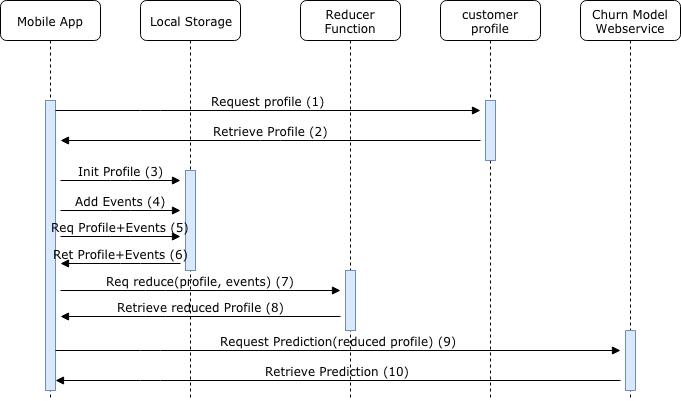

In [7]:
Image(filename="./image/webservice_flow.png")

#### Flujo de secuencia

El flujo para manejar la predicción utilizando una aplicación móvil, con almacenamiento local, se puede describir en 4 fases.

*Inicialización de la aplicación (1 a 3)*: la aplicación se inicializa, realiza una solicitud al perfil del cliente, recupera su valor inicial e inicializa el perfil en el almacenamiento local.

*Aplicaciones (4)*: la aplicación almacena los diferentes eventos que ocurren con la aplicación en una matriz en el almacenamiento local.

*Preparación de la predicción (5 a 8)*: la aplicación desea recuperar una nueva predicción de abandono y, por lo tanto, debe preparar la información que necesita proporcionar al servicio web de abandono. Para ello, realiza una solicitud inicial al almacenamiento local para recuperar los valores del perfil y la matriz de eventos que ha almacenado. Una vez que se recuperan, realiza una solicitud a una función reductora que proporciona estos valores como argumentos, la función redeuctora genera un perfil actualizado* con los eventos locales incorporados de nuevo en este perfil.

*Predicción del servicio web (9 a 10)*: la aplicación realiza una solicitud al servicio web de predicción de abandono, que proporciona el perfil de cliente actualizado*/reducido del paso 8 como parte del payload. El servicio web puede luego utilizar la información proporcionada por el payload para generar la predicción y generar su valor, de vuelta a la aplicación.

#### Tecnologías

Existen bastantes tecnologías que pueden utilizarse para potenciar un servicio web de predicción:

*Funciones*

Las funciones Lambda de AWS, las funciones de Google Cloud y las funciones de Microsoft Azure (aunque el soporte de Python se encuentra actualmente en Beta) ofrecen una interfaz fácil de configurar para implementar fácilmente servicios web escalables.

Por ejemplo, en Azure se podría implementar un servicio web de predicción a través de una función que se parece aproximadamente a esto:

In [ ]:
import logging

import azure.functions as func
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib


def main(req: func.HttpRequest) -> func.HttpResponse:
    logging.info('Python HTTP trigger function processed a request.')
    if req.body:
        try:
            logging.info("Converting Request to DataFrame")
            req_body = req.get_json()
            df_body  = pd.DataFrame([req_body])

            logging.info("Loadding the Prediction Model")
            filename = "model.pckl"
            loaded_model = joblib.load(filename)
            # Features names need to have been added to the pickled model
            feature_names = loaded_model.feature_names
            # subselect only the feature names 
            
            logging.info("Subselecting the dataframe")
            df_subselect = df_body[feature_names]
            
            logging.info("Predicting the Probability")
            result = loaded_model.predict_proba(df_subselect)
            # We are looking at the probba prediction for class 1
            prediction = result[0][1]

            return func.HttpResponse("{prediction}".format(prediction=prediction), status_code=200)

        except ValueError:
            pass
    else:
        return func.HttpResponse(
             "Please pass a name on the query string or in the request body",
             status_code=400
        )

*Contenedores*

Una alternativa a las funciones es implementar una aplicación flask o django a través de un contenedor docker (Amazon ECS, Azure Container Instance o Google Kubernetes Engine). Azure, por ejemplo, proporciona una manera fácil de configurar contenedores de predicción a través de su servicio [Azure Machine Learning](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-deploy-and-where).

*Notebooks*

Diferentes proveedores de notebooks, como [databricks](https://docs.databricks.com/applications/mlflow/models.html) y [dataiku](https://www.dataiku.com/dss/features/model-deployment/), han trabajado notablemente en la simplificación de la implementación del modelo desde sus entornos. Estos tienen la función de configurar un servicio web para un entorno local o implementarlo en sistemas externos como el servicio Azure ML, el motor Kubernetes, etc.

### in App

En ciertas situaciones cuando existen requisitos legales o de privacidad que no permiten que los datos se almacenen fuera de una aplicación o existen restricciones como tener que cargar una gran cantidad de archivos, alojar un modelo dentro de la aplicación suele ser el enfoque correcto.

El kit Android-ML o los gustos de Caffe2 permiten alojar modelos dentro de aplicaciones nativas, mientras que [Tensorflow.js](https://www.tensorflow.org/js) y [ONNXJS](https://github.com/Microsoft/onnxjs) permiten ejecutar modelos directamente en el navegador o en aplicaciones que alojan los javascripts.

## Consideraciones

Además del método de implementación de los modelos, hay algunas consideraciones importantes a tener en cuenta al implementar en producción.

### Complejidad del modelo

La complejidad del propio modelo es la primera consideración a tener en cuenta. Modelos como las regresiones lineales y la regresión logística son bastante fáciles de aplicar y, por lo general, no requieren mucho espacio para almacenar. El uso de un modelo más complejo, como una red neuronal o un conjunto complejo de árboles de decisiones, tomará más tiempo para calcular, más tiempo para cargar en la memoria en el arranque en frío y será más costoso de ejecutar.

### Fuentes de datos

Es importante tener en cuenta la diferencia que podría producirse entre la fuente de datos en producción y la utilizada para el entrenamiento. Si bien es importante que los datos utilizados para el entrenamiento estén sincronizados con el contexto para el que se utilizaría en producción, a menudo no es práctico volver a calcular cada valor para que esté perfectamente sincronizado.

## Conclusión

Elegir cómo implementar modelos predictivos en producción es un asunto bastante complejo, hay diferentes maneras de manejar la gestión del ciclo de vida de los modelos predictivos, diferentes formatos para almacenarlos, múltiples formas de implementarlos y un vasto panorama técnico para elegir.

Comprender los casos de uso específicos, la madurez técnica y analítica del equipo, la estructura general de la organización y sus interacciones, ayuda a obtener el enfoque correcto para implementar modelos predictivos en producción.

[Artículo fuente](https://medium.com/analytics-and-data/overview-of-the-different-approaches-to-putting-machinelearning-ml-models-in-production-c699b34abf86)